In [4]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
 
import os
import pandas as pd
import numpy as np
a = [name for name in os.listdir(".") if os.path.isdir(name)]
d = pd.DataFrame()
for i in a:
    if i != '.git' or i!= 'Test':
        b = os.listdir(i)
        b = np.array(b)
        c = pd.DataFrame(b, columns=['filename'])
        c['Class'] = i
        #append to the master dataframe
        d = d.append(c)

from pathlib import Path


df = d
df.head()

# Construct file path by concatenating fold and file name
df['relative_path'] = df['Class'] + '/' + df['filename'].astype(str)
df = df.sample(frac=1)
label_encoder = preprocessing.LabelEncoder()

df['classID'] = label_encoder.fit_transform(df['Class'])

# Take relevant columns
df = df[['relative_path', 'classID','Class']]
df.head()
df.to_csv('train.csv', index=False)



In [5]:
df

,relative_path,classID,Class
1313,Whimper/L6TCRy-UHQ8_12.wav,24,Whimper
1400,Speech/NRiaznQevTA_150.wav,21,Speech
296,Whoop/BPtHcX-Bezw_120.wav,27,Whoop
309,Whimper/1vZNNVA7AMU_20.wav,24,Whimper
614,Whimper/4H52d8aXYSo_30.wav,24,Whimper
...,...,...,...
499,Snicker/LuLIYG32k6Y_30.wav,20,Snicker
782,Speech/6kD2g6UGREI_190.wav,21,Speech
408,White noise/CCg5sKgUK-s_30.wav,26,White noise
445,Whimper/32KbcPAQ9z0_30.wav,24,Whimper


In [6]:
df.Class.unique()

array(['Whimper', 'Speech', 'Whoop', 'Male speech, man speaking',
       'Rustle', 'Conversation', 'Snicker', 'White noise',
       'Dishes, pots, and pans', 'Singing', 'Smash, crash', 'Breathing',
       'Groan', 'Cupboard open or close', 'Yell',
       'Female speech, woman speaking', 'Children shouting', 'Clapping',
       'Whispering', 'Babbling', 'Drawer open or close', 'Screaming',
       'Battle cry', 'Finger snapping', 'Bellow', 'Dogs', '.git',
       'shatter', 'Wail, moan', 'Test'], dtype=object)

In [7]:
df.shape

(13915, 3)

In [8]:
df= df[df['Class'] != 'Test']

In [9]:
df.shape

(13908, 3)

In [10]:
df= df[df['Class'] != '.git']

In [11]:
df= df[df['Class'] != 'Growling']
df= df[df['Class'] != 'Howl']
df= df[df['Class'] != 'Bark']

In [12]:
df.shape

(13895, 3)

In [13]:
#### Dependencies ####
#### Import Comet for experiment tracking and visual tools
from comet_ml import Experiment
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import tensorflow as tf
# from keras.optimizers import Adam
# from keras.utils import to_categorical

In [14]:
experiment = Experiment(
    api_key="TpJmHUzqkFIYdblKq8rPA9vKW",
    project_name="fyp-audio-processing",
    workspace="shakthi-stack",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shakthi-stack/fyp-audio-processing/e799f8a4e99f415d914fc92bf622ebee



In [15]:
labels = list(df['classID'].unique())

In [16]:
files = dict()
for i in range(len(labels)):
    tmp = df[df['classID'] == labels[i]][:1].reset_index()
    path = df['relative_path']
    files[labels[i]] = path

In [17]:
fn = 'Snicker/6xfMfFenKiM_70.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 16000
Librosa sample rate: 22050


In [18]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -5272 to 4727
Librosa audio file min~max range: -0.16 to -0.16


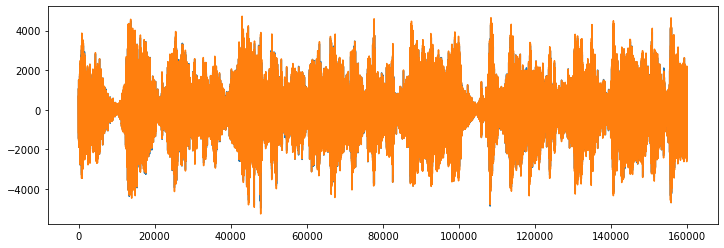

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

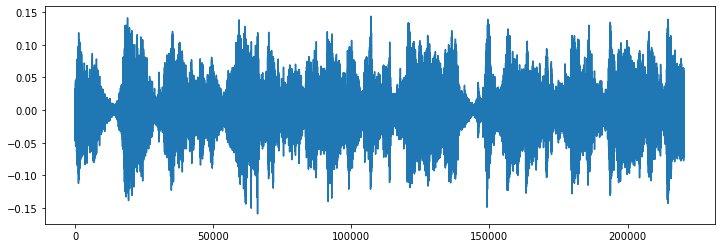

In [20]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)

In [21]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 500)

In [22]:
print(mfccs.shape)

(128, 431)


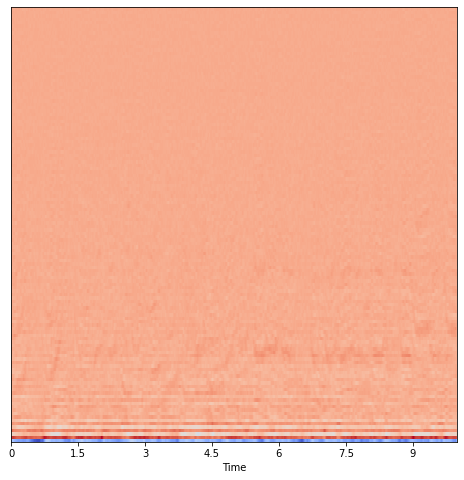

In [23]:
import librosa.display
plt.figure(figsize=(8,8))

librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [24]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=100)
    mfccs_processed = np.mean(mfccs.T,axis=0) 
    return mfccs_processed

In [25]:
features = []
# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    file_name = row['relative_path']
    # os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"])) 
    class_label = row["Class"]
    try:
        data = extract_features(file_name)
        features.append([data, class_label])
    except:
        print("error")
        continue
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


error
error


In [26]:
featuresdf

,feature,class_label
0,"[-279.89996, 96.099754, -43.98774, -6.3563523,...",Whimper
1,"[-268.62698, 148.14798, -15.163095, 45.634914,...",Speech
2,"[-9.320869, 187.64738, -93.49531, 43.26071, -3...",Whoop
3,"[-155.34642, 138.00449, -83.01925, 12.784471, ...",Whimper
4,"[-378.95126, 86.498215, -38.244907, 19.205418,...",Whimper
...,...,...
13888,"[-88.9009, 172.28459, -73.71109, 46.055214, -4...",Snicker
13889,"[-246.6593, 127.06461, -8.019936, 13.740027, -...",Speech
13890,"[-159.00569, 165.43834, -69.719795, 76.69293, ...",White noise
13891,"[-128.18817, 134.94576, -32.327347, 33.55625, ...",Whimper


In [27]:
featuresdf.iloc[0]['feature']

array([-2.79899963e+02,  9.60997543e+01, -4.39877396e+01, -6.35635233e+00,
        2.91896015e-01, -1.65212994e+01, -1.43975902e+00, -4.33694792e+00,
       -1.21778994e+01,  2.35635114e+00, -9.08739924e-01, -9.34692764e+00,
       -1.53014934e+00, -7.04603004e+00, -8.72866249e+00, -3.92472839e+00,
       -6.88577318e+00, -6.14675665e+00, -3.97056794e+00, -5.01152039e+00,
       -1.96393692e+00,  3.48003775e-01, -4.60540438e+00, -4.38085318e+00,
       -2.26007223e+00, -3.91503882e+00, -2.27909970e+00, -2.79440284e-02,
       -1.08115256e+00, -1.35462415e+00,  9.61928964e-01, -4.11485322e-02,
       -2.24134731e+00, -2.82656527e+00, -2.87004423e+00, -1.18400872e+00,
        3.45306583e-02, -6.69414103e-01, -8.95390213e-01,  5.13193488e-01,
        6.54784858e-01,  3.73064190e-01, -4.55013141e-02, -9.98737097e-01,
       -5.90723574e-01, -5.44023693e-01, -2.89117008e-01,  3.73460710e-01,
       -4.60581511e-01, -4.02008384e-01,  7.23151982e-01, -2.89466918e-01,
       -9.88772511e-01, -

In [28]:
from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [29]:
X.shape

(13893, 100)

In [30]:
y

array(['Whimper', 'Speech', 'Whoop', ..., 'White noise', 'Whimper',
       'Speech'], dtype='<U29')

In [31]:
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [32]:
num_labels = yy.shape[1]
filter_size = 2
def build_model_graph(input_shape=(100,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy','AUC'], optimizer='adam')
    return model
model = build_model_graph()

In [33]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 200
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


Epoch 1/200
348/348 [==============================] - 4s 4ms/step - loss: 2.8009 - accuracy: 0.1454 - auc: 0.7911 - val_loss: 2.5758 - val_accuracy: 0.2191 - val_auc: 0.8375
Epoch 2/200
348/348 [==============================] - 1s 4ms/step - loss: 2.5869 - accuracy: 0.1980 - auc: 0.8345 - val_loss: 2.4963 - val_accuracy: 0.2321 - val_auc: 0.8501
Epoch 3/200
348/348 [==============================] - 1s 4ms/step - loss: 2.5181 - accuracy: 0.2166 - auc: 0.8455 - val_loss: 2.4564 - val_accuracy: 0.2479 - val_auc: 0.8558
Epoch 4/200
348/348 [==============================] - 1s 3ms/step - loss: 2.4700 - accuracy: 0.2373 - auc: 0.8526 - val_loss: 2.4145 - val_accuracy: 0.2623 - val_auc: 0.8606
Epoch 5/200
348/348 [==============================] - 1s 3ms/step - loss: 2.4398 - accuracy: 0.2514 - auc: 0.8569 - val_loss: 2.3973 - val_accuracy: 0.2652 - val_auc: 0.8627
Epoch 6/200
348/348 [==============================] - 1s 4ms/step - loss: 2.4143 - accuracy: 0.2598 - auc: 0.8605 - val_loss

In [34]:
# experiment.log_confusion_matrix()
output = model.predict(x_test)

In [35]:
output

array([[5.65250457e-06, 1.80744624e-03, 2.33338758e-01, ...,
        3.59225720e-01, 1.32962927e-01, 2.14455387e-04],
       [9.84037433e-06, 1.64054113e-03, 1.26545853e-03, ...,
        2.00024955e-02, 3.25994962e-03, 5.36233280e-03],
       [1.29646668e-02, 3.11623189e-05, 9.73625629e-06, ...,
        4.86253714e-03, 9.34050986e-05, 1.69972791e-05],
       ...,
       [1.10571145e-05, 9.19650216e-03, 1.09696705e-02, ...,
        4.72280473e-01, 2.69560516e-03, 4.36853807e-05],
       [5.40851150e-03, 5.42794354e-04, 7.01813435e-04, ...,
        9.57900472e-03, 1.09953187e-04, 6.87831733e-03],
       [4.80388444e-05, 8.59592557e-02, 2.37776097e-02, ...,
        1.30768701e-01, 1.29955551e-02, 2.20168411e-04]], dtype=float32)

In [36]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 60.19%
Testing Accuracy: 31.45%


In [37]:
y_test.shape

(2779, 28)

In [38]:
output.shape

(2779, 28)

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_score(y_test, output, multi_class='ovo', average='samples')

0.8698172803966256

In [60]:
import librosa.display
def audiofun(fn):
    librosa_audio, librosa_sample_rate = librosa.load(fn)
    scipy_sample_rate, scipy_audio = wav.read(fn)
    # print("Original sample rate: {}".format(scipy_sample_rate))
    # print("Librosa sample rate: {}".format(librosa_sample_rate))
    mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 100)
    
    # plt.figure(figsize=(8,8))

    librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

    mfccs_processed = np.mean(mfccs.T,axis=0)

    X = np.array(mfccs_processed.tolist())
    x=np.reshape(X,(-1,100))
    output = model.predict(x)
    return output

In [61]:
def top7Classes(output):
    class_arr = []
    #sort output descending
    output_sorted = np.sort(output, axis=1)[:,::-1]
    #first 5 elements of the output
    output_sorted = output_sorted[:,:7]
    #convert output_sorted to 1D array
    output_sorted = np.reshape(output_sorted, -1)
    #convert output_sorted to list
    output_sorted = output_sorted.tolist()
    output= np.reshape(output, -1)
    output = output.tolist()
    index = []
    for i in output_sorted:
        if i in output:
            index.append(output.index(i))
    class_name = [name for name in os.listdir(".") if os.path.isdir(name)]
    class_name.remove('Test')
    class_name.remove('.git')
    # print(class_name)
    # print(index)
    for i in index:
        class_arr.append(class_name[i])
    print(class_arr)
    return class_arr

In [42]:
fn = 'Test/dv_test_1-[AudioTrimmer.com].wav'

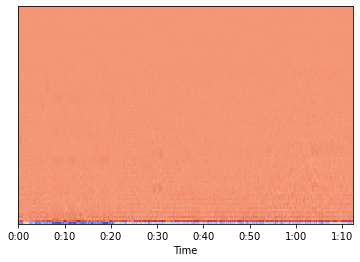

In [43]:
output = audiofun(fn)

In [44]:
output

array([[8.6640511e-03, 3.4526143e-05, 6.6636438e-03, 3.3941753e-02,
        2.1536026e-07, 2.0586676e-04, 8.9822412e-02, 2.0560573e-03,
        2.2224804e-02, 6.0470938e-03, 1.1659545e-02, 8.7026246e-02,
        1.7948933e-04, 1.2478304e-02, 5.3198908e-02, 4.2589866e-02,
        2.8969145e-03, 3.3749946e-04, 2.9553520e-02, 6.6198749e-03,
        1.3377830e-01, 1.8622349e-04, 6.9003612e-02, 3.0313087e-01,
        1.9950582e-02, 4.3461137e-03, 8.0075592e-04, 5.2603029e-02]],
      dtype=float32)

In [45]:
top7Classes(output)

['Whimper', 'Snicker', 'Conversation', 'Female speech, woman speaking', 'Wail, moan', 'Male speech, man speaking', 'Yell']


['Whimper',
 'Snicker',
 'Conversation',
 'Female speech, woman speaking',
 'Wail, moan',
 'Male speech, man speaking',
 'Yell']

In [46]:
fn2 = 'Test/test_2-[AudioTrimmer.com].wav'


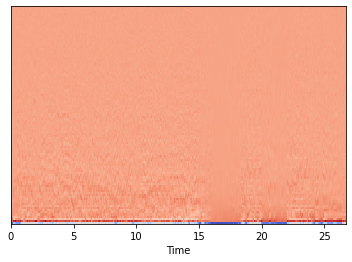

In [47]:
output = audiofun(fn2)

In [48]:
output

array([[0.00924996, 0.00136138, 0.01843526, 0.02641292, 0.00070969,
        0.04760641, 0.01088794, 0.00354182, 0.039224  , 0.0396672 ,
        0.00315731, 0.06209405, 0.00365675, 0.0384504 , 0.03329572,
        0.11277533, 0.02865705, 0.004358  , 0.01822498, 0.01810035,
        0.02251967, 0.00672448, 0.23910259, 0.08733938, 0.08519299,
        0.02612819, 0.00562593, 0.00750028]], dtype=float32)

In [49]:
a = top7Classes(output)
print(a)

['Wail, moan', 'Rustle', 'Whimper', 'Whispering', 'Female speech, woman speaking', 'Clapping', 'Dogs']
['Wail, moan', 'Rustle', 'Whimper', 'Whispering', 'Female speech, woman speaking', 'Clapping', 'Dogs']


In [50]:
toxic_list = ["Bellow","Groan","Screaming","Snicker","Wail, moan","Whimper","Yell"]

In [51]:
def toxic_Class(a):
    count = 0
    for i in a:
        if i in toxic_list:
            count += 1
    if count > 2:
        print("Toxic")
    else:
        print("Not Toxic")

def toxic_Class_tnt(a):
    count = 0
    for i in a:
        if i in toxic_list:
            count += 1
    if count >5:
        a_op = 'high-toxic'
        print("High Possibility of Toxicity")
    elif count <=5 and count>2:
        a_op = 'slight-toxic'
        print("Slight Possibility of Toxicity")
    else: 
        a_op = 'non-toxic'
        print('not toxic')
    return a_op

In [52]:
toxic_Class(a)

Not Toxic


In [53]:
fn3 = 'Test/test_3.wav'

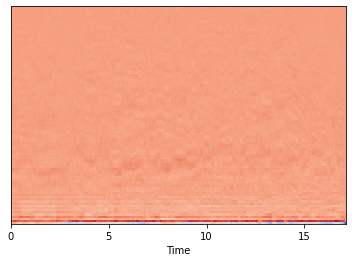

In [54]:
output3 = audiofun(fn3)

In [55]:
output3

array([[1.15643488e-03, 1.69847073e-04, 1.10507266e-04, 1.34132919e-03,
        9.50908907e-06, 1.17604770e-02, 8.14398285e-03, 1.47670765e-09,
        3.22848861e-03, 6.03108492e-04, 1.68663191e-05, 1.22141138e-01,
        7.76283215e-08, 7.01370591e-05, 2.42765285e-02, 4.68227034e-03,
        9.17000230e-04, 6.66946769e-01, 4.21193145e-05, 7.20704813e-03,
        1.30763752e-02, 2.70517745e-07, 1.16846785e-01, 1.94780601e-04,
        4.96365875e-03, 1.09854322e-02, 1.10562192e-03, 3.46407387e-06]],
      dtype=float32)

In [56]:
a = top7Classes(output3)
print(a)

['shatter', 'Female speech, woman speaking', 'Wail, moan', 'Male speech, man speaking', 'Snicker', 'Clapping', 'White noise']
['shatter', 'Female speech, woman speaking', 'Wail, moan', 'Male speech, man speaking', 'Snicker', 'Clapping', 'White noise']


In [57]:
# "Bellow","Groan","Screaming","Snicker","Wail, moan","Whimper","Yell"
toxic_Class(a)

Not Toxic


In [58]:
%run nlp-short.ipynb

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
0
Percentage of unlabelled comments or good comments is  89.83211235124176
Percentage of comments which is present in all categories is  0.019427088882065038
Total r

In [119]:
def final_classification(text_op,audio_op):
    if text_op == 'toxic' and audio_op != 'non-toxic':
        final_op = 'Presence of Domestic Violence is detected'
        pred = 'DV'
    elif text_op == 'non-toxic' and audio_op == 'non-toxic':
        final_op = 'No Presence of Domestic Violence detected'
        pred = 'NDV'
    elif text_op == 'toxic' and audio_op== 'non-toxic':
        final_op = 'Presence of verbal abuse detected, but no signs of actual violence'
        pred = 'NDV'
    elif text_op == 'non-toxic' and audio_op== 'high-toxic':
        final_op = 'Presence of Domestic Violence is highly likely'
        pred = 'DV'
    elif text_op == 'non-toxic' and audio_op== 'slight-toxic':
        final_op = 'Disturbances detected. If conditions worsen it may point to domestic violence'
        pred = 'DV'
    else:
        final_op= 'Error in classification'
    return [final_op,pred]

In [ ]:
print(final_classification())

not toxic
No Presence of Domestic Violence detected


Testing Phase

In [62]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("Test/DomesticViolence/") if isfile(join("Test/DomesticViolence/", f))]

['shatter', 'Female speech, woman speaking', 'Snicker', 'Conversation', 'Wail, moan', 'Babbling', 'Male speech, man speaking']
not toxic
['Male speech, man speaking', 'Whimper', 'Female speech, woman speaking', 'Speech', 'Snicker', 'Wail, moan', 'Conversation']
Slight Possibility of Toxicity
['Female speech, woman speaking', 'Snicker', 'shatter', 'Conversation', 'Dishes, pots, and pans', 'Male speech, man speaking', 'Wail, moan']
not toxic
['shatter', 'Male speech, man speaking', 'Female speech, woman speaking', 'Snicker', 'Dishes, pots, and pans', 'Conversation', 'Wail, moan']
not toxic
['Wail, moan', 'Female speech, woman speaking', 'Whimper', 'Snicker', 'Rustle', 'Dogs', 'Whispering']
Slight Possibility of Toxicity
['Wail, moan', 'shatter', 'Male speech, man speaking', 'Snicker', 'Whimper', 'Groan', 'Conversation']
Slight Possibility of Toxicity
['Whimper', 'Snicker', 'Wail, moan', 'Female speech, woman speaking', 'Conversation', 'Male speech, man speaking', 'Babbling']
Slight Possi

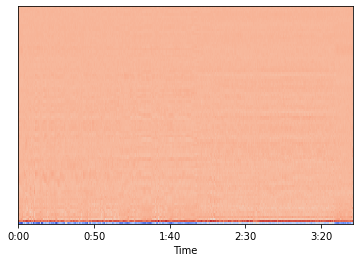

In [63]:
pred_list = []
for i in onlyfiles:
    fn = "Test/DomesticViolence/"+i
    op = audiofun(fn)
    f_op = toxic_Class_tnt(top7Classes(op))
    pred_list.append(f_op)
    

In [64]:
print(pred_list)

['non-toxic', 'slight-toxic', 'non-toxic', 'non-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'non-toxic', 'slight-toxic', 'non-toxic', 'non-toxic', 'non-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'slight-toxic', 'non-toxic', 'non-toxic']


In [65]:
lst1=[]
for i in range(24):
    lst1.append('sample'+str(i+1))

In [66]:
df = pd.DataFrame(list(zip(lst1, pred_list)), columns =['Sample', 'Prediction'])

In [67]:
df

,Sample,Prediction
0,sample1,non-toxic
1,sample2,slight-toxic
2,sample3,non-toxic
3,sample4,non-toxic
4,sample5,slight-toxic
5,sample6,slight-toxic
6,sample7,slight-toxic
7,sample8,slight-toxic
8,sample9,slight-toxic
9,sample10,non-toxic


In [78]:
%run nlp-short.ipynb

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
0
Percentage of unlabelled comments or good comments is  89.83211235124176
Percentage of comments which is present in all categories is  0.019427088882065038
Total r

In [79]:
speech_op = test_dataframe
bga_op = df

In [80]:
speech_op

,Samples,Prediction
0,sample1,non-toxic
1,sample2,toxic
2,sample3,non-toxic
3,sample4,toxic
4,sample5,toxic
5,sample6,non-toxic
6,sample7,toxic
7,sample8,non-toxic
8,sample9,non-toxic
9,sample10,non-toxic


In [81]:
bga_op

,Sample,Prediction
0,sample1,non-toxic
1,sample2,slight-toxic
2,sample3,non-toxic
3,sample4,non-toxic
4,sample5,slight-toxic
5,sample6,slight-toxic
6,sample7,slight-toxic
7,sample8,slight-toxic
8,sample9,slight-toxic
9,sample10,non-toxic


In [84]:
bga_op["Prediction2"] = speech_op["Prediction"]

In [85]:
bga_op

,Sample,Prediction,Prediction2
0,sample1,non-toxic,non-toxic
1,sample2,slight-toxic,toxic
2,sample3,non-toxic,non-toxic
3,sample4,non-toxic,toxic
4,sample5,slight-toxic,toxic
5,sample6,slight-toxic,non-toxic
6,sample7,slight-toxic,toxic
7,sample8,slight-toxic,non-toxic
8,sample9,slight-toxic,non-toxic
9,sample10,non-toxic,non-toxic


In [120]:
final_classification_lst = []
final_prediction_lst = []
for index, row in bga_op.iterrows():
    pred1 = row['Prediction']
    pred2 = row["Prediction2"]
    try:
       op_lst = final_classification(pred2,pred1)
       final_classification_lst.append(op_lst[0])
       final_prediction_lst.append(op_lst[1])
    except:
        print("error")
        continue

In [121]:
df = pd.DataFrame(list(zip(lst1, final_classification_lst, final_prediction_lst)), columns =['Sample', 'Final_Classification', 'Final_Prediction'])

In [122]:
df

,Sample,Final_Classification,Final_Prediction
0,sample1,No Presence of Domestic Violence detected,NDV
1,sample2,Presence of Domestic Violence is detected,DV
2,sample3,No Presence of Domestic Violence detected,NDV
3,sample4,"Presence of verbal abuse detected, but no sign...",NDV
4,sample5,Presence of Domestic Violence is detected,DV
5,sample6,Disturbances detected. If conditions worsen it...,DV
6,sample7,Presence of Domestic Violence is detected,DV
7,sample8,Disturbances detected. If conditions worsen it...,DV
8,sample9,Disturbances detected. If conditions worsen it...,DV
9,sample10,No Presence of Domestic Violence detected,NDV


In [123]:
actual_lst = ['DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','DV','NDV','NDV','NDV','NDV','NDV','NDV']

In [124]:
actual_df = pd.DataFrame(list(zip(lst1, actual_lst)), columns =['Sample', 'Actual_Value'])

In [125]:
actual_df

,Sample,Actual_Value
0,sample1,DV
1,sample2,DV
2,sample3,DV
3,sample4,DV
4,sample5,DV
5,sample6,DV
6,sample7,DV
7,sample8,DV
8,sample9,DV
9,sample10,DV


In [126]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [127]:
confusion_matrix(actual_df['Actual_Value'], df['Final_Prediction'])

array([[11,  7],
       [ 4,  2]], dtype=int64)

In [128]:
accuracy_score(actual_df['Actual_Value'], df['Final_Prediction'])

0.5416666666666666